# 3D map simulation

## Prerequisites

- Knowledge of 3D extraction and datasets used in gammapy, see for instance the [first analysis tutorial](../../starting/analysis_1.ipynb)

## Context

To simulate a specific observation, it is not always necessary to simulate the full photon list. For many uses cases, simulating directly a reduced binned dataset is enough: the IRFs reduced in the correct geometry are combined with a source model to predict an actual number of counts per bin. The latter is then used to simulate a reduced dataset using Poisson probability distribution.

This can be done to check the feasibility of a measurement (performance / sensitivity study), to test whether fitted parameters really provide a good fit to the data etc.

Here we will see how to perform a 3D simulation of a CTA observation, assuming both the spectral and spatial morphology of an observed source.

**Objective: simulate a 3D observation of a source with CTA using the CTA 1DC response and fit it with the assumed source model.**

## Proposed approach:

Here we can't use the regular observation objects that are connected to a `DataStore`. Instead we will create a fake `~gammapy.data.Observation` that contain some pointing information and the CTA 1DC IRFs (that are loaded with `~gammapy.irf.load_cta_irfs`).

Then we will create a `~gammapy.datasets.MapDataset` geometry and create it with the `~gammapy.makers.MapDatasetMaker`.

Then we will be able to define a model consisting of  a `~gammapy.modeling.models.PowerLawSpectralModel` and a `~gammapy.modeling.models.GaussianSpatialModel`. We will assign it to the dataset and fake the count data.


## Imports and versions

In [1]:
%matplotlib inline
import gammapy
gammapy.__version__

'0.17.dev4064+g8aadf0ec5.d20210821'

In [2]:
import numpy as np
import astropy.units as u
import scipy
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, DataStore
from gammapy.datasets import MapDataset
from regions import CircleSkyRegion
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator

## Simulation

In [3]:
# Loading IRFs - one typical HESS IRF 
datastore = DataStore.from_dir('/Users/asinha/HAP-fr/ash_stereo_Prod17_Calib0834_thsq64/')
obs = datastore.obs(23523)
irfs = {'aeff': obs.aeff,
         'psf': obs.psf,
        'edisp': obs.edisp,
        'bkg': obs.bkg
       }

No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None
Missing 'HDUCLAS2' keyword assuming 'BKG'


In [4]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 200 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [27]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_energy_bounds(energy_min=1.0*u.TeV, 
                                         energy_max=20*u.TeV,
                                        nbin=5, per_decade=True, name='energy')
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 7),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_energy_bounds(energy_min=100*u.GeV, 
                                         energy_max=100*u.TeV,
                                        nbin=5, per_decade=True, name='energy_true')
empty = MapDataset.create(geom, name="dataset-simu", energy_axis_true=energy_true)

In [75]:
from gammapy.modeling.models import SpatialModel
from astropy.coordinates.angle_utilities import angular_separation
from gammapy.modeling import Parameter, Parameters


class MyCustomGaussianModel(SpatialModel):
    """My custom Energy Dependent Gaussian model.

    Parameters
    ----------
    lon_0, lat_0 : `~astropy.coordinates.Angle`
        Center position
    sigma_1TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 1 TeV
    sigma_10TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 10 TeV

    """

    tag = "MyCustomGaussianModel"
    is_energy_dependent = True
    lon_0 = Parameter("lon_0", "0 deg")
    lat_0 = Parameter("lat_0", "0 deg", min=-90, max=90)

    sigma_1TeV = Parameter("sigma_1TeV", "1.0 deg", min=0)
    sigma_10TeV = Parameter("sigma_10TeV", "0.2 deg", min=0)

    @staticmethod
    def evaluate(lon, lat, energy, lon_0, lat_0, sigma_1TeV, sigma_10TeV):
        
        print(energy.shape, lon.shape, lat.shape)

        sep = angular_separation(lon, lat, lon_0, lat_0)

        # Compute sigma for the given energy using linear interpolation in log energy
        sigma_nodes = u.Quantity([sigma_1TeV, sigma_10TeV])
        energy_nodes = [1, 10] * u.TeV
        log_s = np.log(sigma_nodes.to("deg").value)
        log_en = np.log(energy_nodes.to("TeV").value)
        log_e = np.log(energy.to("TeV").value)
        sigma = np.exp(np.interp(log_e, log_en, log_s)) * u.deg

        exponent = -0.5 * (sep / sigma) ** 2
        norm = 1 / (2 * np.pi * sigma ** 2)
        print(norm.shape, exponent.shape)
        val = norm * np.exp(exponent)
        print(val.shape)
        return norm * np.exp(exponent)

In [76]:
# Define sky model to used simulate the data.



spatial_model2 = MyCustomGaussianModel(
    lon_0="0.0 deg", lat_0="0.0 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2, amplitude="4e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)

model_simu2 = SkyModel(
    spatial_model=spatial_model2,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu2, bkg_model])
print(models)

(1, 1, 1) (1, 2, 2) (1, 2, 2)
(1, 1, 1) (1, 2, 2)
(1, 2, 2)
Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : MyCustomGaussianModel
  Temporal model type       : 
  Parameters:
    index                   :      2.000   +/-    0.00             
    amplitude               :   4.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0                   :      0.000   +/-    0.00 deg         
    lat_0                   :      0.000   +/-    0.00 deg         
    sigma_1TeV              :      1.000   +/-    0.00 deg         
    sigma_10TeV             :      0.200   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm       

In [77]:
models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str11,float64,str14,int64,float64,float64,bool,str1
spectral,index,2.0000e+00,,0.000e+00,nan,nan,False,
spectral,amplitude,4.0000e-12,cm-2 s-1 TeV-1,0.000e+00,nan,nan,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
spatial,lon_0,0.0000e+00,deg,0.000e+00,nan,nan,False,
spatial,lat_0,0.0000e+00,deg,0.000e+00,-9.000e+01,9.000e+01,False,
spatial,sigma_1TeV,1.0000e+00,deg,0.000e+00,0.000e+00,nan,False,
spatial,sigma_10TeV,2.0000e-01,deg,0.000e+00,0.000e+00,nan,False,
spectral,norm,1.0000e+00,,0.000e+00,nan,nan,False,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,


Now, comes the main part of dataset simulation. We create an in-memory observation and an empty dataset. We then predict the number of counts for the given model, and Poission fluctuate it using `fake()` to make a simulated counts maps. Keep in mind that it is important to specify the `selection` of the maps that you want to produce 

In [78]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51552.33
	duration          : 720000.00 s
	pointing (icrs)   : 266.4 deg, -28.9 deg

	deadtime fraction : 0.0%



In [79]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=2.3 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)

In [80]:
# Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake()

(15, 1, 1) (1, 350, 300) (1, 350, 300)
(15, 1, 1) (15, 350, 300)
(15, 350, 300)


In [81]:
dataset._geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (300, 350, 7)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 6.0 deg x 7.0 deg
	wcs ref    : 0.0 deg, 0.0 deg

In [82]:
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 481851 
  Total background counts         : 468329.77
  Total excess counts             : 13521.23

  Predicted counts                : 480692.40
  Predicted background counts     : 468329.77
  Predicted excess counts         : 12362.63

  Exposure min                    : 6.18e+04 m2 s
  Exposure max                    : 5.26e+11 m2 s

  Number of total bins            : 735000 
  Number of fit bins              : 290948 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17784.33

  Number of models                : 2 
  Number of parameters            : 10
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : MyCustomGaussianModel
    Temporal model type       : 
    Parame

<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2 * dnde [TeV / (cm2 s)]'>

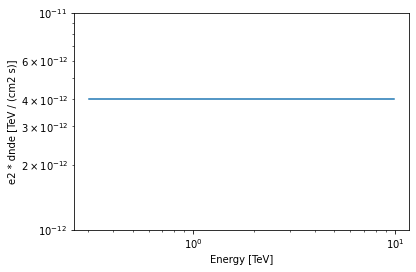

In [83]:
spectral_model.plot(energy_bounds=[0.3,10]*u.TeV, energy_power=2)

The datset has been simultaed. Now look at the excess maps.

In [84]:
dataset.models = None

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

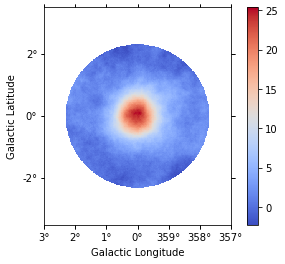

In [85]:
estimator = ExcessMapEstimator(correlation_radius=0.5*u.deg)
res1 = estimator.run(dataset)
res1['sqrt_ts'].plot(add_cbar=True, cmap='coolwarm')

array([[<WCSAxesSubplot:title={'center':'Energy 1.0 TeV - 2.4 TeV '}, ylabel='Galactic Latitude'>,
        <WCSAxesSubplot:title={'center':'Energy 2.4 TeV - 5.5 TeV '}>,
        <WCSAxesSubplot:title={'center':'Energy 5.5 TeV - 8.5 TeV '}>],
       [<WCSAxesSubplot:title={'center':'Energy 8.5 TeV - 13.0 TeV '}, xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
        <WCSAxesSubplot:title={'center':'Energy 13.0 TeV - 20.0 TeV '}, xlabel='Galactic Longitude'>,
        <WCSAxesSubplot:>]], dtype=object)

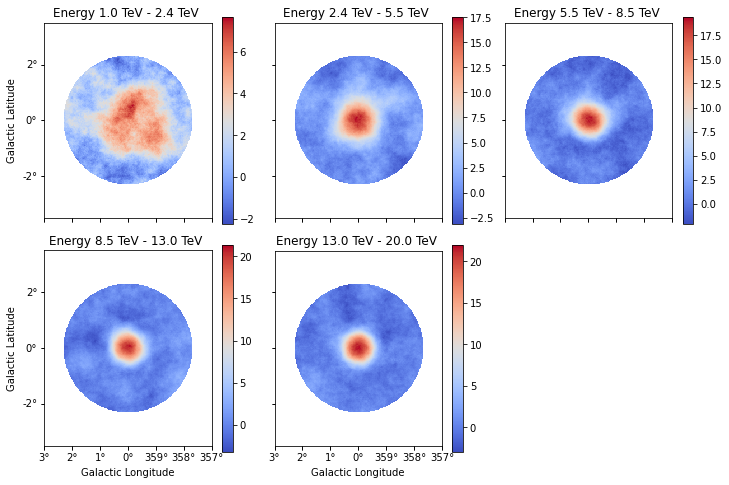

In [86]:
estimator = ExcessMapEstimator(correlation_radius=0.5*u.deg, energy_edges=[1, 2, 5, 10, 13, 20]*u.TeV)
res1 = estimator.run(dataset)
res1['sqrt_ts'].plot_grid(add_cbar=True, cmap='coolwarm')

In [87]:
dataset1 = dataset.copy(name='dataset1')
dataset2 = dataset.copy(name='dataset2')

## Fit


### 3D fit

In [88]:
bkg1 = FoVBackgroundModel(dataset_name=dataset1.name)
models1 = Models([bkg1])
dataset1.models = models1

In [89]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset1])

CPU times: user 155 ms, sys: 14.9 ms, total: 170 ms
Wall time: 169 ms


In [90]:
TS0 = dataset1.stat_sum()

In [91]:
result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str3,float64,float64,float64,bool,str1
spectral,norm,1.0289e+00,,1.482e-03,nan,nan,False,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,


In [92]:
spatial1 = GaussianSpatialModel(frame='galactic')
spectral1 = PowerLawSpectralModel()
sky_model1 = SkyModel(spatial_model=spatial1, 
                      spectral_model=spectral1, name='sky1')

models1.append(sky_model1)
dataset1.models = models1 

In [93]:
spatial1.parameters['lon_0'].value = 0.0
spatial1.parameters['lat_0'].value = 0.0
spatial1.parameters['sigma'].value = 0.2

In [94]:
dataset1.models.names

['dataset1-bkg', 'sky1']

In [95]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset1])

CPU times: user 6.15 s, sys: 362 ms, total: 6.51 s
Wall time: 6.53 s


In [96]:
TS1 = dataset1.stat_sum()
print('detection TS: ',(TS0-TS1))

detection TS:  1641.8750736683505


/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

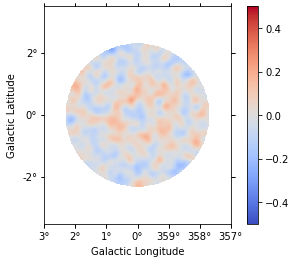

In [97]:
dataset1.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

In [98]:
models1.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str12,str8,str9,float64,str14,float64,float64,float64,bool,str1
dataset1-bkg,spectral,norm,1.0155e+00,,1.610e-03,nan,nan,False,
dataset1-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
dataset1-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
sky1,spectral,index,1.3355e+00,,4.176e-02,nan,nan,False,
sky1,spectral,amplitude,8.8481e-13,cm-2 s-1 TeV-1,8.583e-14,nan,nan,False,
sky1,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
sky1,spatial,lon_0,8.8755e-03,deg,1.060e-02,nan,nan,False,
sky1,spatial,lat_0,8.3807e-03,deg,1.070e-02,-9.000e+01,9.000e+01,False,
sky1,spatial,sigma,2.5887e-01,deg,8.455e-03,0.000e+00,nan,False,


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

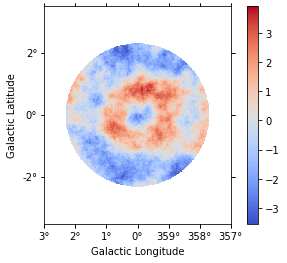

In [99]:
estimator = ExcessMapEstimator(correlation_radius=0.5*u.deg)
res1 = estimator.run(dataset1)
res1['sqrt_ts'].plot(add_cbar=True, cmap='coolwarm')

array([<WCSAxesSubplot:title={'center':'Energy 1.0 TeV - 5.5 TeV '}, xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
       <WCSAxesSubplot:title={'center':'Energy 5.5 TeV - 20.0 TeV '}, xlabel='Galactic Longitude'>],
      dtype=object)

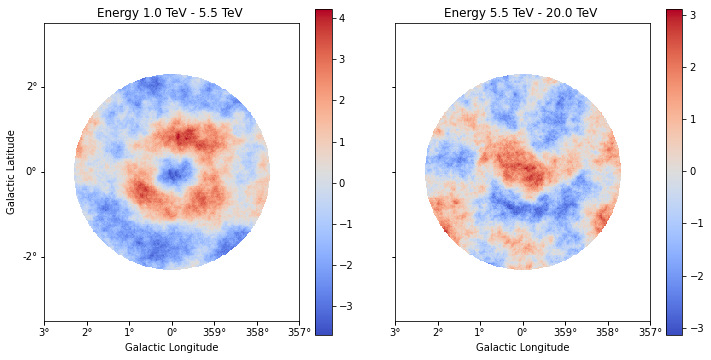

In [100]:
estimator = ExcessMapEstimator(correlation_radius=0.5*u.deg, energy_edges=[0.5, 1, 5, 20]*u.TeV)
res1 = estimator.run(dataset1)
res1['sqrt_ts'].plot_grid(add_cbar=True, cmap='coolwarm')

<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2 * dnde [TeV / (cm2 s)]'>

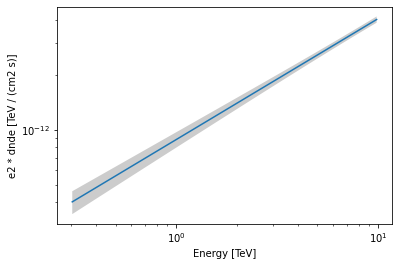

In [101]:
sky_model1.spectral_model.plot(energy_bounds=[0.3,10]*u.TeV, energy_power=2)
sky_model1.spectral_model.plot_error(energy_bounds=[0.3,10]*u.TeV, energy_power=2)

## Fit spectrum in an on-region
- Does this mimic the reflected ?

In [102]:
def fit_different_on(radius=[]):
    results = []
    for r in radius:
        on_region = CircleSkyRegion(center=SkyCoord(0,0, unit='deg', frame='galactic'),
                           radius=r)
        dataset_spectrum = dataset2.to_spectrum_dataset(on_region=on_region)
        spectral2 = PowerLawSpectralModel()
        sky_model2 = SkyModel(spectral_model=spectral2)
        dataset_spectrum.models = sky_model2
        fit = Fit(optimize_opts={"print_level": 0})
        result = fit.run(datasets=[dataset_spectrum])
        results.append(result)
    return results

In [103]:
radius = np.linspace(0.1, 3, 10)
radius = radius*u.deg
print(radius)

[0.1        0.42222222 0.74444444 1.06666667 1.38888889 1.71111111
 2.03333333 2.35555556 2.67777778 3.        ] deg


In [104]:
%%time
results = fit_different_on(radius)

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero en

CPU times: user 4.84 s, sys: 156 ms, total: 5 s
Wall time: 5.01 s


In [105]:
index = []
index_err =[]
amplitude = []
amplitude_err = []
for aresult in results:
    index.append(aresult.parameters['index'].value)
    index_err.append(aresult.parameters['index'].error)
    amplitude.append(aresult.parameters['amplitude'].value)
    amplitude_err.append(aresult.parameters['amplitude'].error)

Text(0, 0.5, 'fitted index')

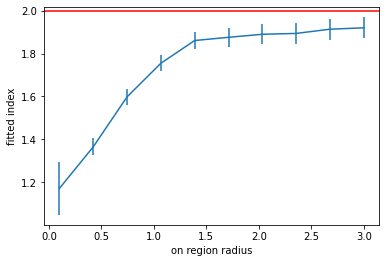

In [108]:
plt.errorbar(x=radius.value, y=index, yerr=index_err)
plt.axhline(model_simu2.parameters['index'].value, color='red')
#plt.axhline(spectral1.parameters['index'].value, color='black',ls='-.')
#plt.axvline(spatial1.parameters['sigma'].value, color='black', ls='--')
plt.xlabel("on region radius")
plt.ylabel("fitted index")

Text(0.5, 0, 'fitted amplitude')

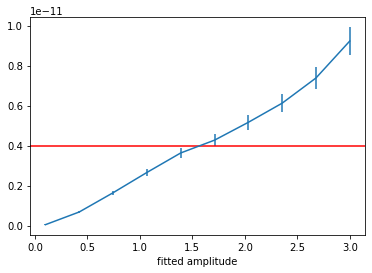

In [107]:
plt.errorbar(x=radius.value, y=amplitude, yerr=amplitude_err)
plt.axhline(model_simu2.parameters['amplitude'].value, color='red')
#plt.axhline(spectral1.parameters['amplitude'].value, color='black', ls='-.')
#plt.axvline(spatial1.parameters['sigma'].value, color='black', ls='--')
plt.xlabel("on region radius")
plt.xlabel("fitted amplitude")